<a href="https://colab.research.google.com/github/arminwitte/llsi/blob/main/example_diss_clone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!git clone https://github.com/arminwitte/llsi.git

fatal: destination path 'llsi' already exists and is not an empty directory.


In [56]:
%cd llsi
# !git checkout frequency_response
!git pull

c:\Users\letsg\git\llsi\llsi
Updating 5a611e6..6617ce0
Fast-forward
 example_diss_clone.ipynb | 286 ++++++++++++++++++++++++++++++++++++-----------
 pyproject.toml           |   7 +-
 uv.lock                  | 241 ++++++++++++++++++++++++++++++++-------
 3 files changed, 427 insertions(+), 107 deletions(-)


From https://github.com/arminwitte/llsi
   5a611e6..6617ce0  main       -> origin/main


In [57]:
%pip install -e .

Note: you may need to restart the kernel to use updated packages.


c:\Users\letsg\git\llsi\.venv\Scripts\python.exe: No module named pip


In [58]:
%cd ..

c:\Users\letsg\git\llsi


In [59]:
try:
  from llsi import SysIdData  # noqa: F401
except (ImportError, KeyError, ModuleNotFoundError, AttributeError):
  print('Stopping RUNTIME to reload. Please run again.')
  exit()

Note: restart runtime after first install run!

In [60]:
import matplotlib.pyplot as plt
import numpy as np

import llsi

In [61]:
d = np.load("llsi/data/heated_wire_data.npy")

In [62]:
t = d[:, 0]
Re = d[:, 1]
Nu = d[:, 2]

In [63]:
data = llsi.SysIdData(t=t, Re=Re, Nu=Nu)
data.equidistant(305002)
print(data.time().shape)
data.center()
data.downsample(18)
data.lowpass(1, 10)
data, test_set = data.split(0.8)
data.crop(start=1000)
data.center()
print(1 / data.Ts)

(305002,)
Splitting at 13556
239.9995820843808


In [77]:
# mod1 = llsi.sysid(data, "Nu", "Re", (0, 200, 0), method="arx", settings={"lambda": 2e1})
mod1 = llsi.sysid(data, "Nu", "Re", (2, 2, 0), method="arx", settings={"lambda": 1e-6})
mod2 = llsi.sysid(
    data,
    "Nu",
    "Re",
    3,
    method="pem",
    settings={"init": "po-moesp", "minimizer_kwargs": {"method": "BFGS"}},
)


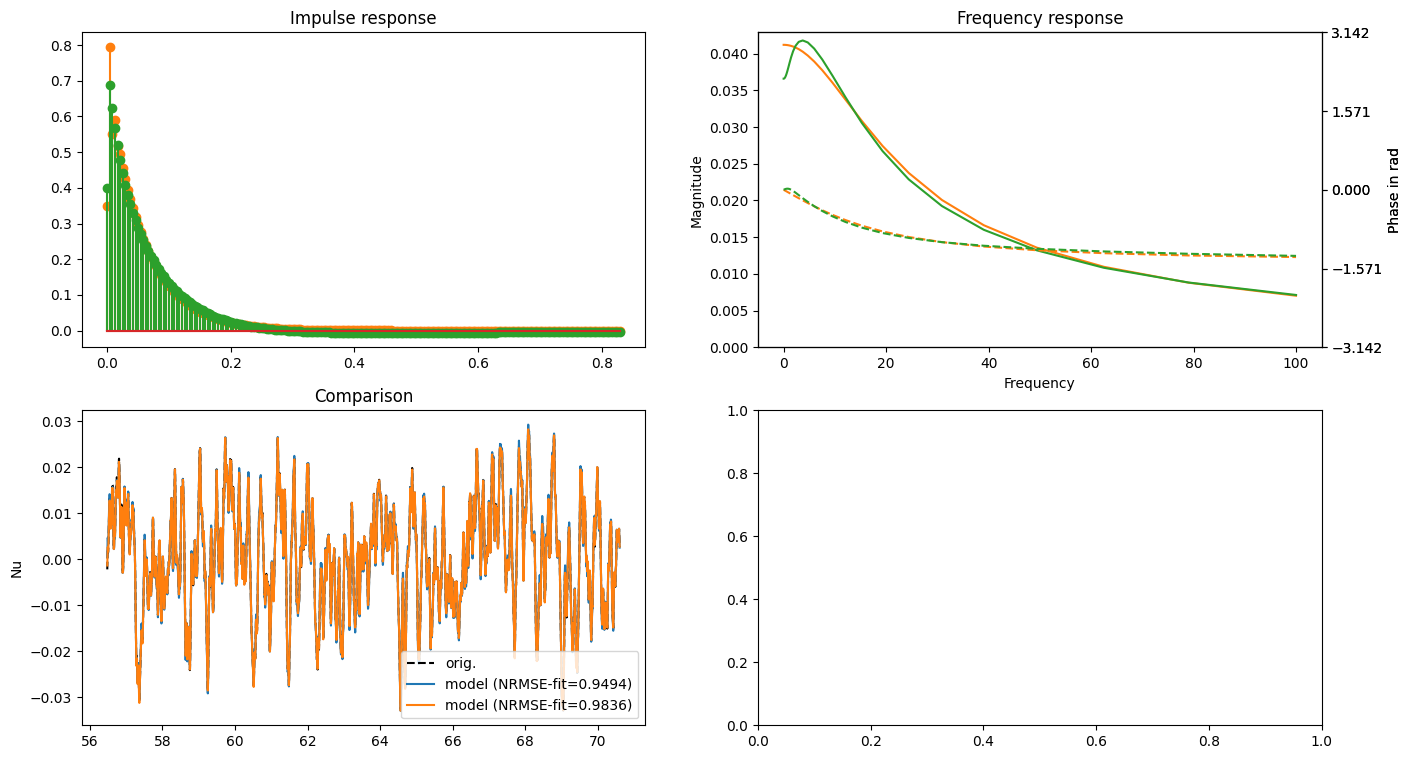

In [78]:
with llsi.Figure() as fig:
    fig.plot([mod1, mod2], "impulse")
    fig.plot([mod1, mod2], "frequency")
    fig.plot(
        {"mod": [mod1, mod2], "data": test_set, "y_name": "Nu", "u_name": "Re"},
        "compare",
    )

[[0.34847481]
 [0.79564212]
 [0.55101649]
 [0.58911938]
 [0.51767905]]


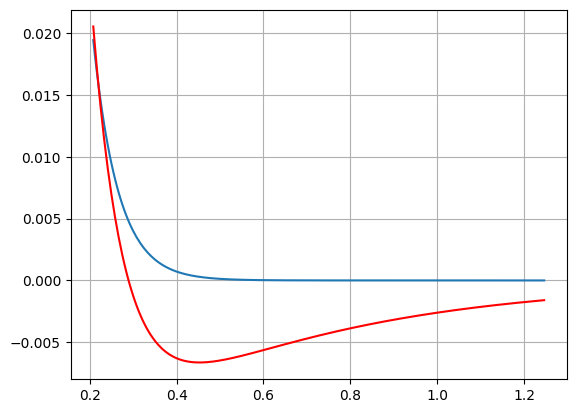

In [79]:
fig, ax = plt.subplots()
ti1, i1 = mod1.impulse_response(300)
ti2, i2 = mod2.impulse_response(300)
plt.plot(ti1[50:], i1[50:])
plt.plot(ti2[50:], i2[50:], "r")
plt.grid(True)

print(i1[:5])
# print(i2[:5])

## Comparison with statsmodels SARIMAX

We will now train a SARIMAX model using `statsmodels` and compare its performance with the `llsi` models on the test set.

**Note on SARIMAX Performance:**
Standard `SARIMAX` treats exogenous variables (`exog`) as static regressors. To capture the dynamic response (transfer function) of the system, we explicitly construct a matrix of lagged inputs (a Finite Impulse Response or FIR basis) and pass it as `exog`. We will use **3 lags** as requested.

Creating 2 lagged features for exogenous variable...
Training SARIMAX...


c:\Users\letsg\git\llsi\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12556
Model:               SARIMAX(2, 0, 2)   Log Likelihood               69903.687
Date:                Sun, 28 Dec 2025   AIC                        -139789.374
Time:                        01:23:46   BIC                        -139722.432
Sample:                             0   HQIC                       -139766.969
                              - 12556                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.759e-06   8.29e-06     -0.574      0.566    -2.1e-05    1.15e-05
x1             0.0015   8.38e-05     18.267      0.000       0.001       0.002
x2             0.0009      0.000      8.263      0.0

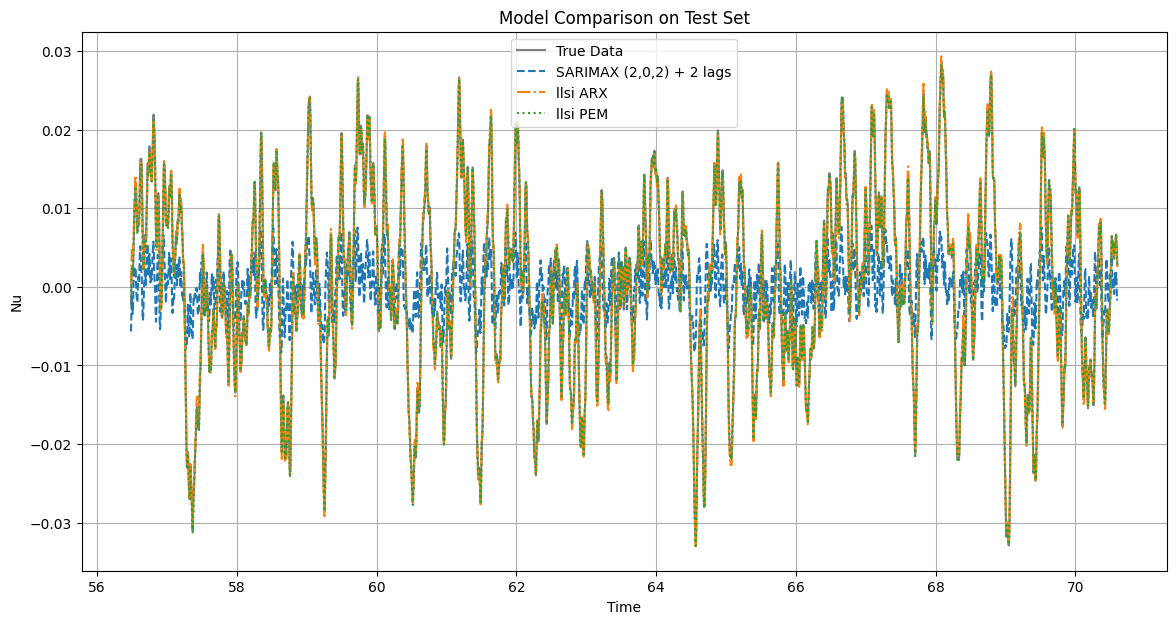

Fits (NRMSE):
SARIMAX: 0.1539
llsi ARX: 0.9494
llsi PEM: 0.9836


In [81]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Prepare training data
endog_train = data["Nu"]
exog_train = data["Re"]

# Prepare test data
endog_test = test_set["Nu"]
exog_test = test_set["Re"]
t_test = test_set.time()

# --- FIX: Create lagged exogenous variables ---
# SARIMAX treats exog as static. We need to manually add lags to model dynamics.
def create_lagged_exog(u, lags):
    N = len(u)
    X = np.zeros((N, lags + 1))
    for i in range(lags + 1):
        # Shift u by i
        X[i:, i] = u[:N-i]
    return X

# Use 3 lags as requested
n_lags = 2
print(f"Creating {n_lags} lagged features for exogenous variable...")
exog_train_lagged = create_lagged_exog(exog_train, n_lags)
exog_test_lagged = create_lagged_exog(exog_test, n_lags)

# Define and fit SARIMAX model
# Using order (2, 0, 2) for the noise/internal dynamics
print("Training SARIMAX...")
mod_sarimax = sm.tsa.statespace.SARIMAX(
    endog_train,
    exog=exog_train_lagged,
    order=(2, 0, 2),
    trend='c'
)
res_sarimax = mod_sarimax.fit(disp=False)
print(res_sarimax.summary())

# Predict with SARIMAX
start_idx = len(endog_train)
end_idx = start_idx + len(endog_test) - 1
pred_sarimax = res_sarimax.predict(
    start=start_idx,
    end=end_idx,
    exog=exog_test_lagged
)

# Simulate llsi models on test set
y_mod1 = mod1.simulate(exog_test)
y_mod2 = mod2.simulate(exog_test)

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(t_test, endog_test, label='True Data', color='black', alpha=0.5)
plt.plot(t_test, pred_sarimax, label=f'SARIMAX (2,0,2) + {n_lags} lags', linestyle='--')
plt.plot(t_test, y_mod1, label='llsi ARX', linestyle='-.')
plt.plot(t_test, y_mod2, label='llsi PEM', linestyle=':')

plt.legend()
plt.title('Model Comparison on Test Set')
plt.xlabel('Time')
plt.ylabel('Nu')
plt.grid(True)
plt.show()

# Calculate fits (NRMSE)
def nrmse(y_true, y_pred):
    return 1 - np.linalg.norm(y_true - y_pred) / np.linalg.norm(y_true - np.mean(y_true))

fit_sarimax = nrmse(endog_test, pred_sarimax)
fit_mod1 = nrmse(endog_test, y_mod1.ravel())
fit_mod2 = nrmse(endog_test, y_mod2.ravel())

print(f"Fits (NRMSE):")
print(f"SARIMAX: {fit_sarimax:.4f}")
print(f"llsi ARX: {fit_mod1:.4f}")
print(f"llsi PEM: {fit_mod2:.4f}")